<center>
<img src="../../img/beeline_data_school_logo.png">
# Школа данных "Билайн"
#### Интенсивный курс по изучению машинного обучения и анализа данных
<img src="../../img/beeline_logo.jpg" height="240" width="240">
## Авторы материала: преподаватели Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий, магистрант ВМК МГУ Колмаков Евгений
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

## Домашнее задание 4. Сравнение алгоритмов классификации на наборах данных репозитория UCI. Решение

В рамках данного задания нужно выбрать один из наборов данных для задачи классификации из [репозитория UCI](http://archive.ics.uci.edu/ml/), выбрать несколько алгоритмов классификации и сравнить их на этом наборе данных.

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
figsize(12, 8)

Populating the interactive namespace from numpy and matplotlib


**Выберите любой набор данных для задачи классификации из [репозитория UCI](http://archive.ics.uci.edu/ml/) и загрузите его, используя функцию urlopen**

In [2]:
import sys
if sys.version_info.major == 2:
    from urllib import urlopen
elif sys.version_info.major == 3:
    from urllib.request import urlopen

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/" +\
        "pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

**Выведите основные характеристики выборки и разделите выборку на обучение и контроль**

In [3]:
from sklearn.cross_validation import train_test_split

# Print basic data stats: 
# number of objects, number of features, number of classes 
print("Number of objects:", data.shape[0], 
      "\nNumber of features:", data.shape[1] - 1,
     "\nNumber of classes:", len(np.unique(data[:, 8]))) 

# Extract objects and labels from data
X, y = data[:, :8], data[:, 8]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.3, random_state=3)

Number of objects: 768 
Number of features: 8 
Number of classes: 2


## 1. Классификаторы без настройки параметров 

**Выберите несколько (2-3) классификаторов из sklearn. Для удобства (чтобы не переписывать один и тот же код для каждого классификатора) можно создать список классификаторов (который, например, может состоять из пар вида (classifier_instance(), 'classifier name'))**

In [5]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

classifiers = [(SVC(), 'SVC'), (KNeighborsClassifier(), 'kNN'),
               (LogisticRegression(), 'Log-regression')]

**С помощью 5-кратной кросс-валидации оцените качество каждого классификатора на обучающей выборке. Используйте функцию cross_val_score. Попробуйте использовать разные метрики качества (параметр scoring)**

In [6]:
from sklearn.cross_validation import cross_val_score

n_folds = 5
scores = []

# Do it for each classifier
for clf, _ in classifiers:
    clf_scores = cross_val_score(clf, X_train, y_train,
                        scoring='accuracy', cv=n_folds)
    scores.append(np.mean(clf_scores))

# Print the name of classifier with
# the best score and the score
i_max = np.argmax(scores)
print("Best classifier:", classifiers[i_max][1],
         "\nMean score:", scores[i_max])

Best classifier: Log-regression 
Mean score: 0.778279681551


**Обучите те же классификаторы без параметров на всей обучающей выборке и проверьте их качество на тестовой выборке. Является ли лучшим классификатор, который имеет наибольшее качество на кросс-валидации?**

In [7]:
from sklearn.metrics import accuracy_score

scores = []

# Do it for each classifier
for clf, _ in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

# Print the name of classifier with
# the best score and the score
i_max = np.argmax(scores)
print("Best classifier:", classifiers[i_max][1],
         "\nMean score:", scores[i_max])

Best classifier: Log-regression 
Mean score: 0.744588744589


## 2. Классификаторы с настройкой параметров 

**Настройте параметры выбранных вами алгоритмов с помощью GridSearchCV и выберите лучший классификатор**

In [8]:
from sklearn.grid_search import GridSearchCV

classifiers_and_params = \
    [(SVC(), {'C': np.logspace(start=-3, stop=3, num=20), 
    'gamma': np.logspace(start=-4, stop=3, num=20)}, 'SVC'), 
    (KNeighborsClassifier(), {'n_neighbors': np.arange(3, 50, 3)}, 'kNN'),
    (LogisticRegression(), {'penalty': ['l1', 'l2'], 
    'C': np.logspace(start=-2, stop=3, num=30)}, 'Log-regression')]
    
n_folds = 5
scores = [] 
clfs = []

# Do it for each classifier
for clf, params, _ in classifiers_and_params:
    clfs.append(GridSearchCV(clf, param_grid=params,
        scoring='accuracy', cv=n_folds).fit(X_train, y_train))
    scores.append(clfs[-1].best_score_)

# Print the name of classifier with
# the best score, the score and the params
i_max = np.argmax(scores)
print("Best classifier:", classifiers_and_params[i_max][2],
      "\nBest parameters:", clfs[i_max].best_params_,
         "\nBest score:", scores[i_max])

Best classifier: Log-regression 
Best parameters: {'penalty': 'l1', 'C': 1.1721022975334805} 
Best score: 0.785847299814


**Для лучшего классификатора и набора параметров для него выберите более мелкую сетку (для того чтобы уточнить лучшие значения параметров). Для этого классификатора настройте параметры по обучающей выборке с помощью GridSearchCV. Постройте график зависимости среднего качества на кросс-валидации от значений параметров**

Best classifier: Log-regression 
Best parameters: {'penalty': 'l1', 'C': 1.1899999999999999} 
Best score: 0.787709497207


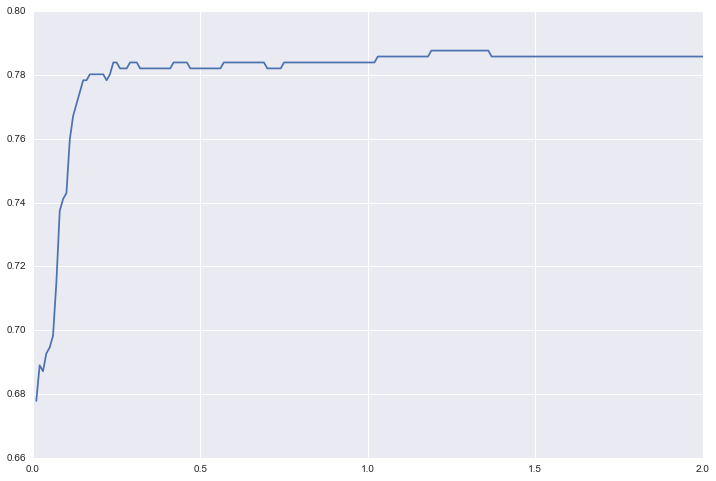

In [9]:
clf_params = {'penalty': ['l1'], 'C': 
    np.linspace(start=0.01, stop=2, num=200)}
grid = GridSearchCV(LogisticRegression(), param_grid=clf_params, 
        scoring='accuracy', refit=True, cv=n_folds).fit(X_train, y_train)
clf_best_score = grid.best_score_
clf_best_params = grid.best_params_
clf_best = grid.best_estimator_

mean_validation_scores = \
    [grid.grid_scores_[i][1] for i in range(len(grid.grid_scores_))]
plot(clf_params['C'], mean_validation_scores)

# Print the best parameters and score
print("Best classifier: Log-regression",
      "\nBest parameters:", clf_best_params,
         "\nBest score:", clf_best_score)

**Для полученной модели посчитайте качество на тестовой выборке и сравните его с качеством, полученным без настройки параметров**

In [10]:
y_pred = clf_best.predict(X_test)
clf_score = accuracy_score(y_test, y_pred)

# Print the score
print("Score on the test set:", clf_score)

Score on the test set: 0.748917748918


**Можно поварьировать параметр scoring и позапускать написанный код ещё раз. Изменится ли лучший классификатор?**

## Ссылки:

 - <a href="http://archive.ics.uci.edu/ml/">UCI Machine Learning Repository</a> 
 - <a href="http://scikit-learn.org/stable/index.html">Scikit-learn documentation</a>